Для исследования получим данные из БД авиакомпании (обработка запросов в отдельном файле sql_query.sql), а также информацию о фестивалях 2018 года с сайта.

In [1]:
# Импортируем файлы и получаем по ним информацию:
from scipy import stats as st
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import math

import requests # Импорт библиотеки для запросов к серверу
from bs4 import BeautifulSoup # Импорт библиотеки для автоматического парсинга странички

Парсер для сбора с сайта данных о 11 крупнейших фестивалях с помощью библиотеки BeautifulSoup. Информаци сохраним в переменной festivals.

In [2]:
URL='https://code.s3.yandex.net/learning-materials/data-analyst/festival_news/index.html'
req = requests.get(URL) # GET-запрос
soup = BeautifulSoup(req.text, 'lxml')

table = soup.find('table',attrs={"id": "best_festivals"})

heading_table = [] 
for row in table.find_all('th'):
        heading_table.append(row.text)

content=[]
for row in table.find_all('tr'): 
    if not row.find_all('th'): 
            content.append([element.text for element in row.find_all('td')])

festivals = pd.DataFrame(content, columns=heading_table) 
festivals

,Название фестиваля,Место проведения,Дата проведения
0,Музыкальный фестиваль «Усадьба Jazz»,Екатеринбург,01.07.2018
1,Фестиваль музыки и технологий Alfa Future People,Нижний Новгород,10.08.2018
2,"Фестиваль еды «О, да! Еда!»",Санкт-Петербург,21.07.2018
3,Доброфест,Ярославль,29.07.2018
4,Park Live,Москва,28.07.2018
5,Пикник Афиши,Москва,04.08.2018
6,VK FEST,Санкт-Петербург,29.07.2018
7,"Фестиваль «О, да! Еда!»",Иркутск,25.08.2018
8,"Фестиваль «О, да! Еда!»",Владивосток,02.09.2018
9,Видфест,Москва,08.09.2018


Результаты нужных запросов сохранены в файлы csv. Прочитаем их и выведем по ним информацию о типе данных.

In [3]:
query_1 = pd.read_csv('/datasets/query_1.csv')
query_3 = pd.read_csv('/datasets/query_3.csv')

In [4]:
def info_and_sample(data):
    print(data.sample(3))
    print()
    print(data.info())

In [5]:
info_and_sample(query_1)

                model  flights_amount
6  Cessna 208 Caravan            4557
2      Boeing 737-300             630
0     Airbus A319-100             607

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
model             8 non-null object
flights_amount    8 non-null int64
dtypes: int64(1), object(1)
memory usage: 256.0+ bytes
None


In [6]:
info_and_sample(query_3)

              city  average_flights
30         Когалым         3.161290
92  Ханты-Мансийск         8.419355
90            Ухта         3.000000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 2 columns):
city               101 non-null object
average_flights    101 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.7+ KB
None


Поля с информацией по рейсам должны быть целочисленные. Перед этим нужно сделать окургление в большую сторону.

In [7]:
def ceil(x):
    return math.ceil(x)

query_3['average_flights'] = query_3['average_flights'].apply(ceil).astype('int')

Построим следующие графики: 
- топ-10 городов по количеству рейсов,
- топ моделей самолетов и количество рейсов, 
- города и количество рейсов, 
- топ-10 городов и количество рейсов.

Чтобы автоматизировать процесс построения графиков, напишем функцию hist.

In [8]:
def hist(x,y, data, title):
    fig, ax = plt.subplots(figsize=(x,y))        # размер графика
    ax.barh(data.iloc[:,0], data.iloc[:,1], color='palevioletred') # горизонтальный bar по данным + задаем цвет
    ax.set_title(title, loc='left', pad=10, fontweight="bold")   # заголовок графика + задаем шрифт
    for s in ['top','bottom','left','right']:                    # убираю все границы графика
        ax.spines[s].set_visible(False)                          # 
    ax.grid(b=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.2)  # задаю только промежуточные границы по значениям
    for i in ax.patches:                                                     # цикл по значениям
        ax.text(i.get_width()+2, i.get_y()+0.5, str(round((i.get_width()), 2)),   # задаю отступ (+) для подписи
                fontsize=10, fontweight='bold', color='grey')                     # задаю шрифт и цвет подписи значения
    plt.show() 

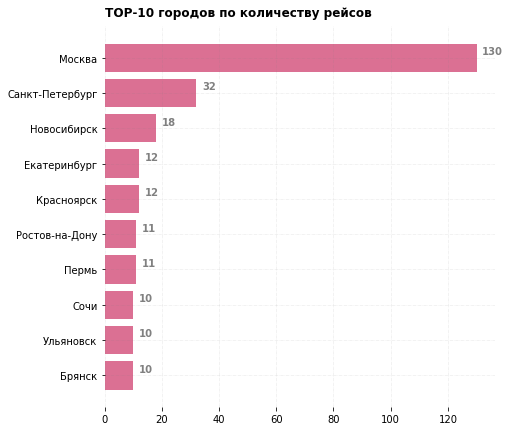

In [9]:
top10 = query_3.sort_values('average_flights', ascending=False).head(10)

hist(7, 7, top10.sort_values('average_flights'), 'TOP-10 городов по количеству рейсов')

Москва и Санкт-Петербург занимат лидирующие позиции по количеству рейсов.

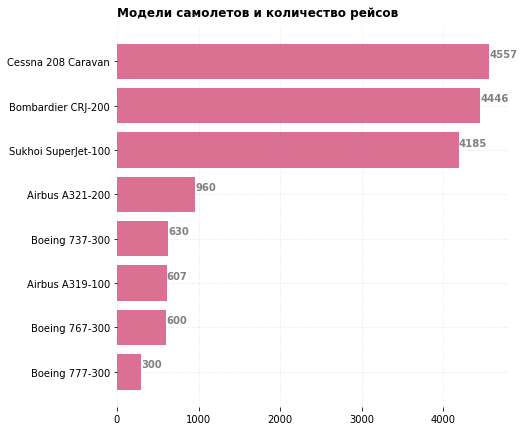

In [10]:
hist(7, 7, query_1.sort_values('flights_amount'), 'Mодели самолетов и количество рейсов')

Самые популярные по количеству рейсов самолеты моделей Cessna 208 Caravan, Bombardier CRJ-200 и Sukhoi Superjet-100

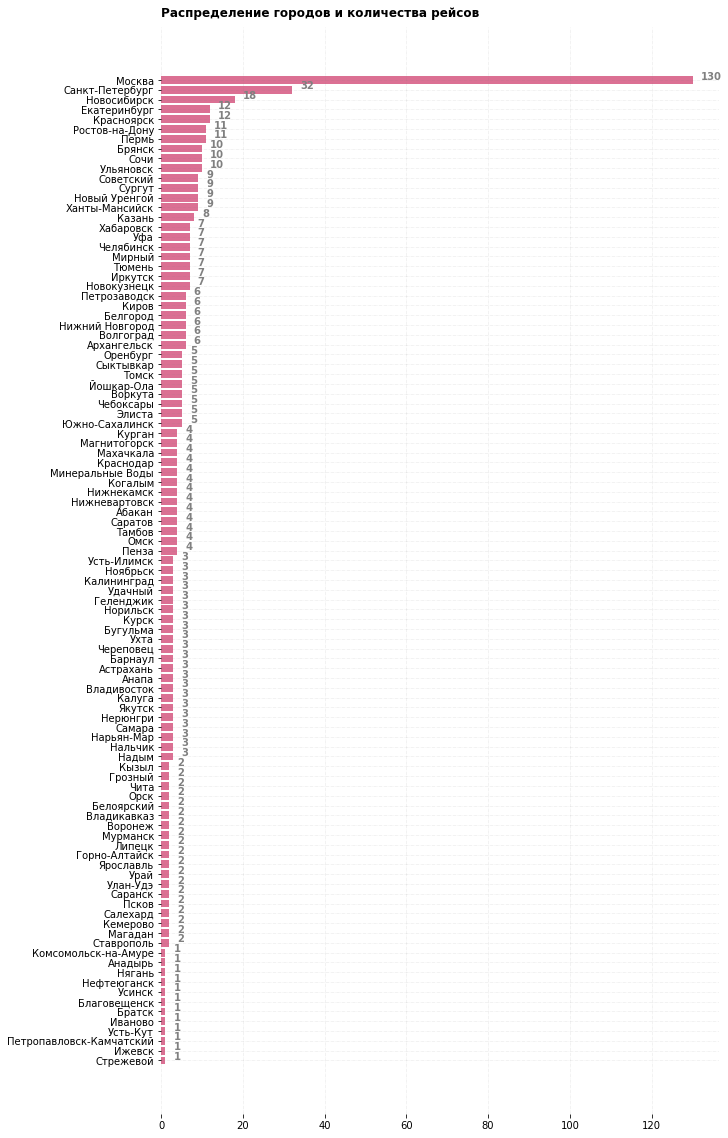

In [11]:
hist(10, 20, query_3.sort_values('average_flights'), 'Распределение городов и количества рейсов')

Посмотрим, а у каких городов больше всего рейсов?

In [12]:
query_3.groupby('average_flights').agg({'city': 'unique'}).reset_index()

,average_flights,city
0,1,"[Анадырь, Благовещенск, Братск, Иваново, Ижевс..."
1,2,"[Белоярский, Владикавказ, Воронеж, Горно-Алтай..."
2,3,"[Анапа, Астрахань, Барнаул, Бугульма, Владивос..."
3,4,"[Абакан, Когалым, Краснодар, Курган, Магнитого..."
4,5,"[Воркута, Йошкар-Ола, Оренбург, Сыктывкар, Том..."
5,6,"[Архангельск, Белгород, Волгоград, Киров, Нижн..."
6,7,"[Иркутск, Мирный, Новокузнецк, Тюмень, Уфа, Ха..."
7,8,[Казань]
8,9,"[Новый Уренгой, Советский, Сургут, Ханты-Манси..."
9,10,"[Брянск, Сочи, Ульяновск]"


Разброс по городам не равномерный, в лидеры выходят города-миллионники. По данному графику можно прослеживать мобильность населения по городам.

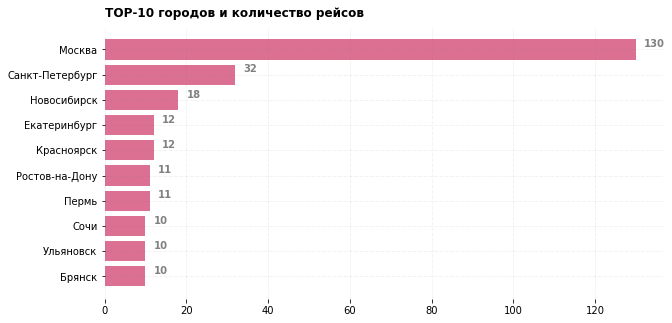

In [13]:
hist(10, 5, top10.sort_values('average_flights'), 'TOP-10 городов и количество рейсов')

В топ городов по количеству рейсов входят города - миллионники (более 10 передетов в день).

Далее проверим гипотезу **H0 «Средний спрос на билеты во время фестивалей не отличается от среднего спроса на билеты в обычное время».**
    
Для этого надо импортировать результат последнего запроса. В нём дана информация о номере недели, количестве проданных билетов за неделю, есть ли на этой неделе фестиваль и его название.

In [14]:
query_last = pd.read_csv('/datasets/query_last.csv')

avg_demand_fest_time = query_last.query('festival_name == festival_name')['ticket_amount']
avg_demand_other_time = query_last.query('festival_name != festival_name')['ticket_amount']

In [15]:
# Критический уровень статистической значимости. Если p-value будет меньше него, нужно отвергнуть гипотезу
alpha = 0.05 

# Проверка гипотезы о равенстве средних двух совокупностей
results = st.ttest_ind(avg_demand_fest_time, avg_demand_other_time, equal_var = True)    

print('p-значение:', round(results.pvalue,6))
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.096889
Не получилось отвергнуть нулевую гипотезу


Не получилось опровергнуть нулевую гипотезу. Хоть полученные средние спросы (кол-во билетов) и не одинаковы, с вероятностью почти 10% такое различие можно получить случайно.

Крупнейшие фестивали проходят в таких городах, как: Москва, Санкт-Петербург, Екатеринбург, Нижний Новгород, Иркутск, Тверь, Владивосток и Ярославль (судя по информации на сайте). Что и частично подтверждается анализом количества рейсов по этим городам и поиска топовых значений.

Самые популярные по количеству рейсов самолеты моделей Cessna 208 Caravan, Bombardier CRJ-200 и Sukhoi Superjet-100. Это значит, что на данный момент это самые перспективные модели самолетов.

В топ городов по количеству рейсов входят города - миллионники (более 10 передетов в день). 

Нельзя сказать (судя по проверке гипотезы), что спрос на рейсы во время провередения фестивалей выше, чем в остальные дни. Это значит, что провередение фестивалей в городе - не показатель спроса на авиаперелеты. Нужно закладывать и другие факторы влияния на продаваемость билетов (например, проведение экономических форумов, маштабных спортивнх мероприятий или экономическую занятость населения).